## NLP Project | Supervised Learning with Quora Dataset
### By Josh Ho

### Project Workflow - Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 

Steps:
- Load Data
- Exploration
- Text Cleaning
- Feature Engineering
- Modeling

### Load Data

In [2]:
# Import modules
import pandas as pd
import numpy as np

In [3]:
# Load dataset
quora = pd.read_csv('quora_data.csv')
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# Filter and rename columns
quora = quora[['question1','question2','is_duplicate']]
quora.columns = ['Q1','Q2','Is_Duplicate']

quora.head()

,Q1,Q2,Is_Duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
quora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Q1            404289 non-null  object
 1   Q2            404288 non-null  object
 2   Is_Duplicate  404290 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [6]:
# Check for number of rows where the question is a duplicate
len(quora[quora['Is_Duplicate'] == 1])

149263

After examining the dataset, we can see that:
* Is_Duplicate == 0 means that the row for question 1 and question 2 are not duplicates
* Is_Duplicate == 1 means that the row for question 1 and question 2 are duplicates are very similar

In [7]:
# Check for nulls
quora.isna().sum()

Q1              1
Q2              2
Is_Duplicate    0
dtype: int64

In [8]:
# Examine null rows
quora[quora['Q1'].isna()]

,Q1,Q2,Is_Duplicate
363362,NaN,My Chinese name is Haichao Yu. What English na...,0


In [9]:
# Examine null rows
quora[quora['Q2'].isna()]

,Q1,Q2,Is_Duplicate
105780,How can I develop android app?,NaN,0
201841,How can I create an Android app?,NaN,0


Let's drop these rows, as we need a pair of questions to discern if it has a duplicate or not to train our model. Thus, these rows are unhelpful as it is a single question with no pair, making them irrelevant for our model.

In [10]:
# Drop nulls
quora.dropna(inplace=True)

# Confirm removal
print(quora.shape)
quora.isna().sum()

(404287, 3)


Q1              0
Q2              0
Is_Duplicate    0
dtype: int64

In [11]:
# Check for duplicate rows (not the comparision of questions as to whether the Is_Duplicate column == 1)
print(quora.shape)
len(quora[quora.duplicated])

(404287, 3)


0

No duplicate rows!

### Exploration

We can visualize the statistics of the dataset using histograms and bar graphs to help interpret the data. We can conduct analysis on statistics such as:
- Number of characters in each question
- Number of words in each question
- View the top stopwords
- View the top words that appear

We will conduct some light pre-cleaning to allow for more intuitive results by:
- Converting text columns to string dtype
- Removing punctuation
- Removing uppercase
- Removing numbers and non-English characters

In [12]:
# Import modules
from nltk.corpus import stopwords
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
# Change columns to string
quora['Q1'] = quora['Q1'].astype(str)
quora['Q2'] = quora['Q2'].astype(str)

# Remove punctuation
quora['Q1'] = quora['Q1'].str.replace('[^\w\s]','', regex=True)
quora['Q2'] = quora['Q2'].str.replace('[^\w\s]','', regex=True)

# Remove uppercase
quora['Q1'] = quora['Q1'].str.lower()
quora['Q2'] = quora['Q2'].str.lower()

In [14]:
# Removing non-english characters
quora['Q1'] = quora['Q1'].replace(r'[^A-Za-z0-9 ]+', ' ', regex=True)
quora['Q2'] = quora['Q2'].replace(r'[^A-Za-z0-9 ]+', ' ', regex=True)

# Removing numbers
quora['Q1'] = quora['Q1'].str.replace(r'\d+',' ', regex=True)
quora['Q2'] = quora['Q2'].str.replace(r'\d+',' ', regex=True)

In [15]:
quora.head()

,Q1,Q2,Is_Duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,why am i mentally very lonely how can i solve it,find the remainder when math math is divided by,0
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


#### Number of Characters in Each Question

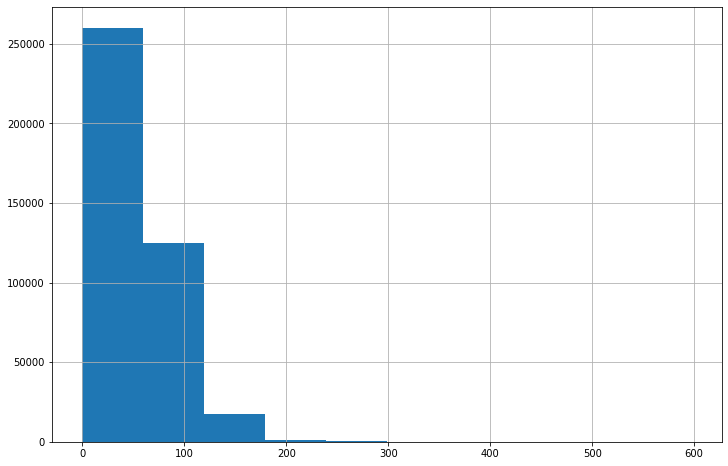

In [16]:
# Q1
quora['Q1'].str.len().hist(figsize=(12,8));

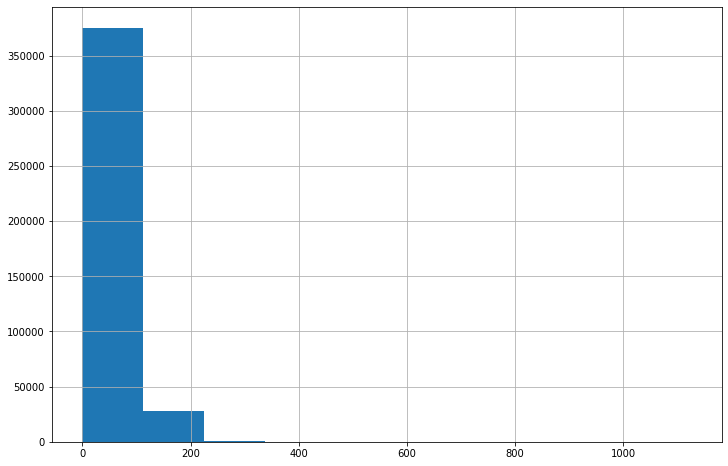

In [17]:
# Q2
quora['Q2'].str.len().hist(figsize=(12,8));

#### Number of Words in Each Question

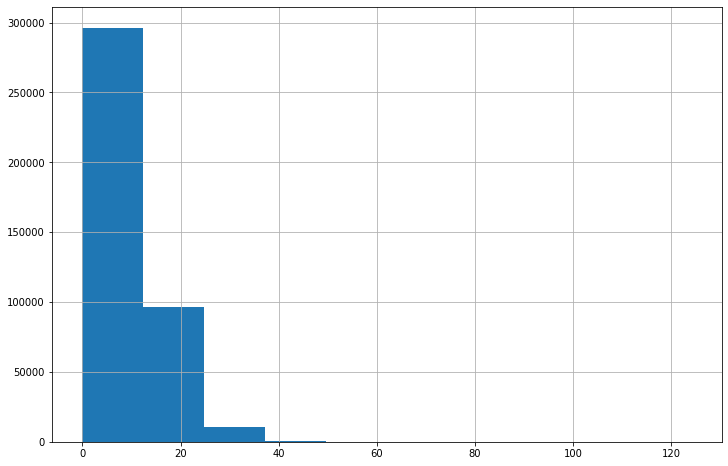

In [18]:
# Q1
quora['Q1'].str.split().map(lambda x: len(x)).hist(figsize=(12,8));

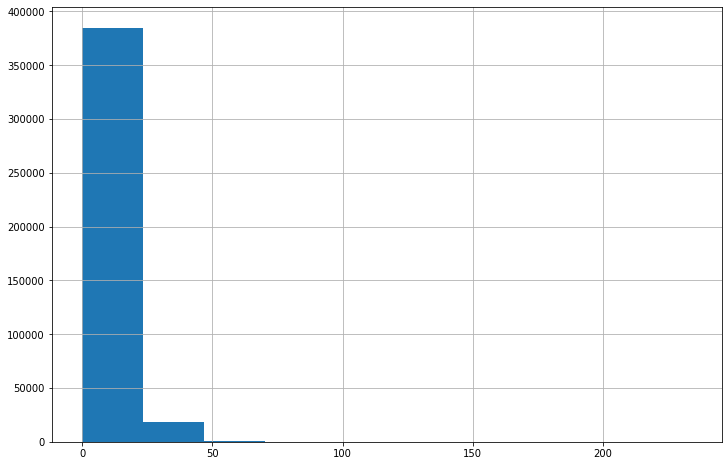

In [19]:
# Q2
quora['Q2'].str.split().map(lambda x: len(x)).hist(figsize=(12,8));

#### Top Stopwords

In [20]:
# Q1
stop = stopwords.words('english')

corpus = []
count = quora['Q1'].str.split()
count = count.values.tolist()
corpus = [word for i in count for word in i]

from collections import defaultdict

dict=defaultdict(int)
for word in corpus:
    if word in stop:
        dict[word]+=1

top=sorted(dict.items(), key=lambda x:x[1],reverse=True)[:10] 

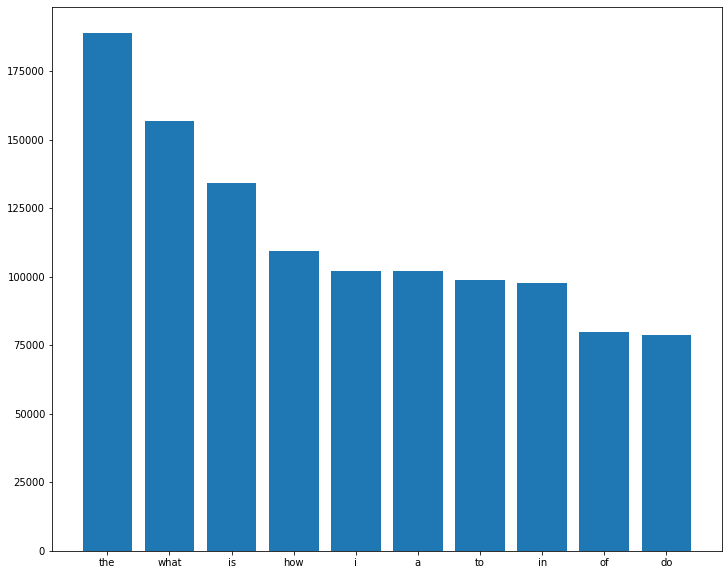

In [21]:
x,y=zip(*top)
fig = plt.gcf()
fig.set_size_inches(12,10)
plt.bar(x,y);

In [22]:
# Q2
corpus = []
count = quora['Q2'].str.split()
count = count.values.tolist()
corpus = [word for i in count for word in i]

from collections import defaultdict

dict=defaultdict(int)
for word in corpus:
    if word in stop:
        dict[word]+=1

top=sorted(dict.items(), key=lambda x:x[1],reverse=True)[:10] 

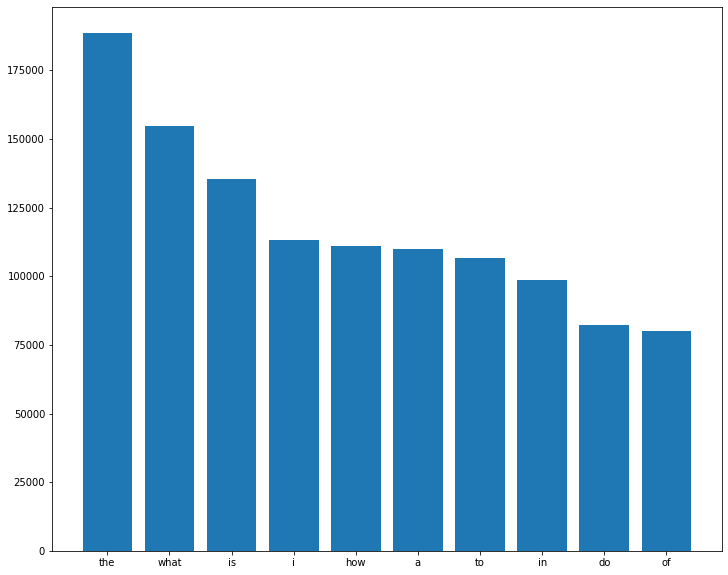

In [23]:
x,y=zip(*top)
fig = plt.gcf()
fig.set_size_inches(12,10)
plt.bar(x,y);

#### Top Words That Appear

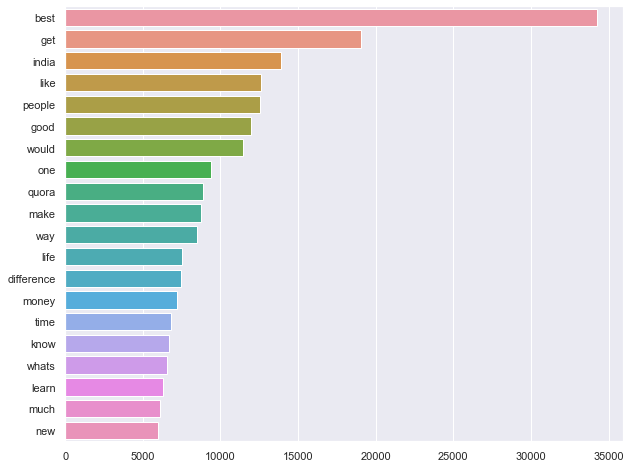

In [24]:
# Q1
texts = quora['Q1'].str.split()
texts = texts.values.tolist()
corpus = [word for i in texts for word in i]

counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word, count in most[:75]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x=y,y=x);

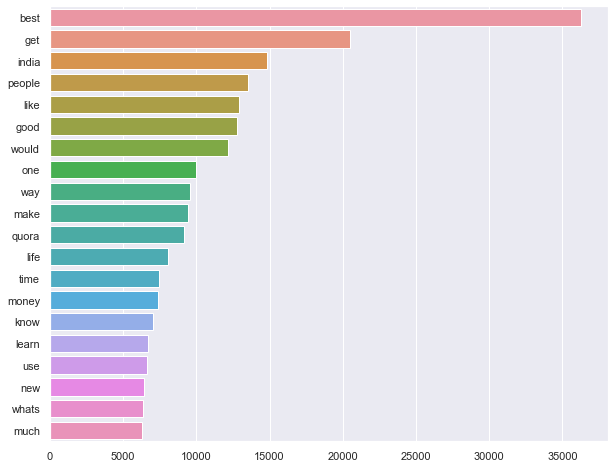

In [25]:
# Q2
texts = quora['Q2'].str.split()
texts = texts.values.tolist()
corpus = [word for i in texts for word in i]

counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word, count in most[:75]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x=y,y=x);

### Cleaning

Now that we have a better idea of our data and made some changes to the structure of our data, let us now cleaning the actual text portion of our data. This will focus on cleaning the actual text through several techniques to prepare it for our model. These techniques include:
- Tokenization
- Removing stopwords
- Normalizing (Stemming or Lemmatization)
- Converting data in form of lists to strings
- Removing duplicate words in a sentence

In [26]:
# Import modules
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import OrderedDict

In [27]:
# Tokenization by space (1m17s)
tokens = nltk.word_tokenize

quora['Q1'] = quora.apply(lambda x: nltk.word_tokenize(x['Q1']), axis=1)
quora['Q2'] = quora.apply(lambda x: nltk.word_tokenize(x['Q2']), axis=1)

In [28]:
# Remove stop words with list comprehension (12.9s)
stop = stopwords.words('english')

quora['Q1'] = quora['Q1'].apply(lambda x: [text for text in x if text not in stop])
quora['Q2'] = quora['Q2'].apply(lambda x: [text for text in x if text not in stop])

#### Normalization
There are 2 main techniques used to normalize text data - stemming and lemmatization. Let's see which is more optimal for our use-case, as well as how many additional letters are removed after each technique is executed.

In [29]:
# Prepare normalization DataFrames
quora_stem = quora.copy()
quora_lam = quora.copy()

In [30]:
# Use stemming to normalize text using snowball stemmer (48.1s)
ps = SnowballStemmer('english')

quora_stem['Q1'] = quora_stem['Q1'].apply(lambda x: [ps.stem(words_sent) for words_sent in x])
quora_stem['Q2'] = quora_stem['Q2'].apply(lambda x: [ps.stem(words_sent) for words_sent in x])

In [31]:
# Use lammetization to normalize text using wordnet lemmatizer (16.8s)
lemmatizer = WordNetLemmatizer()

quora_lam['Q1'] = quora_lam['Q1'].apply(lambda x: [lemmatizer.lemmatize(text) for text in x])
quora_lam['Q2'] = quora_lam['Q2'].apply(lambda x: [lemmatizer.lemmatize(text) for text in x])

Let's look at comparison of all 3 DataFrames - Quora (before any normalization), quora_stem (using stemming), and quora_lam (using lammetization).

In [32]:
# Original Quora DataFrame
q = []
df = quora['Q1']

for row in df:
    for word in row:
        for letter in word:
            q.append(letter)
print('Total letters:', len(q))

quora.head()

Total letters: 13097501


,Q1,Q2,Is_Duplicate
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0
2,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0
3,"[mentally, lonely, solve]","[find, remainder, math, math, divided]",0
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


In [33]:
# Quora DataFrame using stemming
stem = []
df = quora_stem['Q1']

for row in df:
    for word in row:
        for letter in word:
            stem.append(letter)
print('Total letters:', len(stem))

quora_stem.head()

Total letters: 11408241


,Q1,Q2,Is_Duplicate
0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",0
1,"[stori, kohinoor, kohinoor, diamond]","[would, happen, indian, govern, stole, kohinoo...",0
2,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dns]",0
3,"[mental, lone, solv]","[find, remaind, math, math, divid]",0
4,"[one, dissolv, water, quik, sugar, salt, metha...","[fish, would, surviv, salt, water]",0


In [34]:
# Quora DataFrame using lammetization
lam = []
df = quora_lam['Q1']

for row in df:
    for word in row:
        for letter in word:
            lam.append(letter)
print('Total letters:', len(lam))

quora_lam.head()

Total letters: 12816684


,Q1,Q2,Is_Duplicate
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0
2,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0
3,"[mentally, lonely, solve]","[find, remainder, math, math, divided]",0
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


In [35]:
len(lam)-len(stem)

1408443

After analysis, we can observe that:
- Stemming takes ~50 seconds to normalize the data, while lammetization takes only ~20 seconds
- Stemming removes 1408575 (1376549?) additional letters than lammetization does, which means we are losing more characters, potentially affecting our model
- Normalizing with the snowball stemmer method seems to be more inaccurate than the wordnet lemmatizer, as we are left with words such as 'increas' instead of 'increase', or 'dissolv' instead of 'dissolve', potentially affecting our model

In conclusion, we will go forward and apply lammetization for our normalization procedure!

In [36]:
# Convert list to strings
quora_lam['Q1'] = [' '.join(map(str, l)) for l in quora_lam['Q1']]
quora_lam['Q2'] = [' '.join(map(str, l)) for l in quora_lam['Q2']]

In [37]:
# Remove duplicate words from sentences
quora_lam['Q1'] = (quora_lam['Q1'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))
quora_lam['Q2'] = (quora_lam['Q2'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))

In [38]:
# Create a new DataFrame from cleaned data
quora_c = quora_lam.copy()
quora_c.head()

,Q1,Q2,Is_Duplicate
0,step guide invest share market india,step guide invest share market,0
1,story kohinoor diamond,would happen indian government stole kohinoor ...,0
2,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,mentally lonely solve,find remainder math divided,0
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


### Feature Engineering
Let's conduct some feature engineering on our cleaned dataset. We will be adding features using:
- TF-IDF
- Character Count
- Word Count
- Number of Same Words in Both Questions
- Number of Same Letters in Both Questions

In [39]:
# Import modules
from sklearn.feature_extraction.text import TfidfVectorizer

#### TF-IDF

In [40]:
# Use TF-IDF for text vectorization
q1 = quora_c['Q1'].tolist()
q2 = quora_c['Q2'].tolist()

vectorizer = TfidfVectorizer()
val = q1 + q2
v = vectorizer.fit_transform(val)
q1_vectors = v[: (v.shape[0]//2) , :]
q2_vectors = v[(v.shape[0]//2): , :]

In [41]:
# Add product of question vectors to list (1m47s)
cosine = []
for i in range(q1_vectors.shape[0]):
    cosine.append(q1_vectors[i].dot(q2_vectors[i].T).toarray()[0][0])

#### Character Count

In [42]:
quora_c['Q1_Char_Count'] = quora_c['Q1'].str.len()
quora_c['Q2_Char_Count'] = quora_c['Q2'].str.len()

#### Word Count

In [43]:
quora_c['Q1_Word_Count'] = quora_c['Q1'].str.split().map(lambda x: len(x))
quora_c['Q2_Word_Count'] = quora_c['Q2'].str.split().map(lambda x: len(x))

#### Number of Same Words

In [44]:
def convert(string):
    lst = list(string.split(" "))
    return lst

In [45]:
quora_c['List1'] = quora_c['Q1'].apply(convert)
quora_c['List2'] = quora_c['Q2'].apply(convert)

In [46]:
quora_c['Same_Words'] = [set(x[7]) & set(x[8]) for x in quora_c.values]
quora_c['Same_Words'] = quora_c['Same_Words'].str.len()

#### Number of Same Letters

In [47]:
quora_c['Same_Letters'] = [set(x[0]) & set(x[1]) for x in quora_c.values]
quora_c['Same_Letters'] = quora_c['Same_Letters'].str.len()

In [48]:
quora_c.head()

,Q1,Q2,Is_Duplicate,Q1_Char_Count,Q2_Char_Count,Q1_Word_Count,Q2_Word_Count,List1,List2,Same_Words,Same_Letters
0,step guide invest share market india,step guide invest share market,0,36,30,6,5,"[step, guide, invest, share, market, india]","[step, guide, invest, share, market]",5,16
1,story kohinoor diamond,would happen indian government stole kohinoor ...,0,22,58,3,8,"[story, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",2,12
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,44,36,6,5,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",2,12
3,mentally lonely solve,find remainder math divided,0,21,27,3,4,"[mentally, lonely, solve]","[find, remainder, math, divided]",0,7
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,60,29,10,5,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",2,14


### Modeling
For our modeling portion, we will isolate and scale our numeric features, then feed the data into 3 different classifiers:
- Logistic Regression
- Random Forest
- Multinomial Naive Bayes

In [74]:
# Import modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [50]:
# Drop object columns
quora_scaled = quora_c[[
                     'Q1_Char_Count', 'Q2_Char_Count',
                     'Q1_Word_Count', 'Q2_Word_Count', 
                     'Same_Words', 'Same_Letters'
                     ]]

In [51]:
# Scale numeric values 
scaler = MinMaxScaler()
quora_scaled = pd.DataFrame(scaler.fit_transform(quora_scaled), columns=quora_scaled.columns)

In [52]:
# Add cosine column from dot product of Q1 and Q2 vectors
quora_scaled['Cosine'] = cosine

In [53]:
quora_scaled.head()

,Q1_Char_Count,Q2_Char_Count,Q1_Word_Count,Q2_Word_Count,Same_Words,Same_Letters,Cosine
0,0.110769,0.058027,0.117647,0.064103,0.208333,0.64,0.968062
1,0.067692,0.112186,0.058824,0.102564,0.083333,0.48,0.597548
2,0.135385,0.069632,0.117647,0.064103,0.083333,0.48,0.277168
3,0.064615,0.052224,0.058824,0.051282,0.000000,0.28,0.000000
4,0.184615,0.056093,0.196078,0.064103,0.083333,0.56,0.230025


In [70]:
# Set target variable, and indepedent variables
X = quora_scaled
y = quora_c['Is_Duplicate']

# Prepare train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X training shape:", X_train.shape)
print("X test shape:", X_test.shape)
print("y training shape:", y_train.shape)
print("y test shape:", y_test.shape)

X training shape: (323429, 7)
X test shape: (80858, 7)
y training shape: (323429,)
y test shape: (80858,)


#### Logistic Regression

In [107]:
# Prepare model
model = LogisticRegression()
cross_val = KFold(n_splits=7, random_state=42, shuffle=True)

# Output model train score
scores = cross_val_score(model, X_train, y_train, cv=cross_val, scoring='roc_auc')
percent = round(scores.mean(), 4) * 100
print(f'Train Set Score: {percent}%')

# Test score
scores = cross_val_score(model, X_test, y_test, cv=cross_val, scoring='roc_auc')
percent = round(scores.mean(), 4) * 100
print(f'Test Set Score: {percent}%')

Train Set Score: 74.38%
Test Set Score: 74.32%


#### K-Nearest Neighbors

In [109]:
# Prepare model
model = KNeighborsClassifier()
cross_val = KFold(n_splits=7, random_state=42, shuffle=True)

# Output model train score
scores = cross_val_score(model, X_train, y_train, cv=cross_val, scoring='roc_auc')
percent = round(scores.mean(), 4) * 100
print(f'Train Set Score: {percent}%')

# Test score
scores = cross_val_score(model, X_test, y_test, cv=cross_val, scoring='roc_auc')
percent = round(scores.mean(), 4) * 100
print(f'Test Set Score: {percent}%')

Train Set Score: 74.81%
Test Set Score: 73.31%


#### Naive Bayes

In [108]:
# Prepare model
model = MultinomialNB()
cross_val = KFold(n_splits=7, random_state=42, shuffle=True)

# Output model train score
scores = cross_val_score(model, X_train, y_train, cv=cross_val, scoring='roc_auc')
percent = round(scores.mean(), 4) * 100
print(f'Train Set Score: {percent}%')

# Test score
scores = cross_val_score(model, X_test, y_test, cv=cross_val, scoring='roc_auc')
percent = round(scores.mean(), 4) * 100
print(f'Test Set Score: {percent}%')

Train Set Score: 72.55%
Test Set Score: 72.47%


#### Random Forest

In [111]:
# Prepare model (4m41s)
model = RandomForestClassifier()
cross_val = KFold(n_splits=7, random_state=42, shuffle=True)

# Output model train score
scores = cross_val_score(model, X_train, y_train, cv=cross_val, scoring='roc_auc')
percent = round(scores.mean(), 4) * 100
print(f'Train Set Score: {percent}%')

# Test score
scores = cross_val_score(model, X_test, y_test, cv=cross_val, scoring='roc_auc')
percent = round(scores.mean(), 4) * 100
print(f'Test Set Score: {percent}%')

Train Set Score: 79.56%
Test Set Score: 77.56%
